Copyright (c) Meta Platforms, Inc. and affiliates.
All rights reserved.

This source code is licensed under the license found in the
watermark_anything.NSE file in the root directory of this source tree.

The project is CC-BY-NC licensed, as found in the LICENSE file of the github.

In [1]:
# Watermark Anything With Localized Messages

### Imports / Model Loading

In [2]:
# must be run in the root folder
%cd ..

/home/wh/ywy/watermark-anything-main


In [3]:
import os
import numpy as np
from PIL import Image

import torch
import torch.nn.functional as F
from torchvision.utils import save_image

from watermark_anything.data.metrics import msg_predict_inference
from notebooks.inference_utils import (
    load_model_from_checkpoint, 
    default_transform, 
    create_random_mask, 
    unnormalize_img,
    plot_outputs,
    msg2str
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# to load images
def load_img(path):
    img = Image.open(path).convert("RGB")
    img = default_transform(img).unsqueeze(0).to(device)
    return img

# Load the model from the specified checkpoint
exp_dir = "checkpoints"
json_path = os.path.join(exp_dir, "params.json")
ckpt_path = os.path.join(exp_dir, 'wam_mit.pth') 
wam = load_model_from_checkpoint(json_path, ckpt_path).to(device).eval()

/home/wh/ywy/ywy_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


making attention of type 'vanilla' with 64 in_channels
Working with z of shape (1, 68, 32, 32) = 69632 dimensions.
making attention of type 'vanilla' with 64 in_channels
Model loaded successfully from checkpoints/wam_mit.pth
{'embedder_config': 'configs/embedder.yaml', 'augmentation_config': 'configs/all_augs_multi_wm.yaml', 'extractor_config': 'configs/extractor.yaml', 'attenuation_config': 'configs/attenuation.yaml', 'embedder_model': 'vae_small', 'extractor_model': 'sam_base', 'nbits': 32, 'img_size': 256, 'img_size_extractor': 256, 'attenuation': 'jnd_1_3_blue', 'scaling_w': 2.0, 'scaling_w_schedule': None, 'scaling_i': 1.0, 'roll_probability': 0.2, 'multiple_w': 1.0, 'nb_wm_eval': 5, 'optimizer': 'AdamW,lr=1e-4', 'optimizer_d': None, 'scheduler': 'CosineLRScheduler,lr_min=1e-6,t_initial=100,warmup_lr_init=1e-6,warmup_t=5', 'epochs': 200, 'batch_size': 8, 'batch_size_eval': 16, 'temperature': 1.0, 'workers': 8, 'to_freeze_embedder': None, 'lambda_w': 1.0, 'lambda_w2': 6.0, 'lambda_

In [7]:
# Seed 
seed = 42
torch.manual_seed(seed)

# Parameters
img_dir = "assets/images"  # Directory containing the original images
num_imgs = 2  # Number of images to watermark from the folder
proportion_masked = 0.5  # Proportion of the image to be watermarked (0.5 means 50% of the image)

# create output folder
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

### One localized watermark per image

In [12]:
# define a 32-bit message to be embedded into the images
wm_msg = wam.get_random_msg(1)  # [1, 32]
print(f"Original message to hide: {msg2str(wm_msg[0])}")

# Iterate over each image in the directory
for img_ in os.listdir(img_dir)[:num_imgs]:
    # Load and preprocess the image
    img_pt = load_img(os.path.join(img_dir, img_))  # [1, 3, H, W]
    
    # Embed the watermark message into the image
    outputs = wam.embed(img_pt, wm_msg)

    # Create a random mask to watermark only a part of the image
    mask = create_random_mask(img_pt, num_masks=1, mask_percentage=proportion_masked)  # [1, 1, H, W]
    img_w = outputs['imgs_w'] * mask + img_pt * (1 - mask)  # [1, 3, H, W]

    # Detect the watermark in the watermarked image
    preds = wam.detect(img_w)["preds"]  # [1, 33, 256, 256]
    mask_preds = F.sigmoid(preds[:, 0, :, :])  # [1, 256, 256], predicted mask
    bit_preds = preds[:, 1:, :, :]  # [1, 32, 256, 256], predicted bits
    
    # Predict the embedded message and calculate bit accuracy
    pred_message = msg_predict_inference(bit_preds, mask_preds).cpu().float()  # [1, 32]
    bit_acc = (pred_message == wm_msg).float().mean().item()

    # Save the watermarked image and the detection mask
    mask_preds_res = F.interpolate(mask_preds.unsqueeze(1), size=(img_pt.shape[-2], img_pt.shape[-1]), mode="bilinear", align_corners=False)  # [1, 1, H, W]
    save_image(unnormalize_img(img_w), f"{output_dir}/{img_}_wm.png")
    save_image(mask_preds_res, f"{output_dir}/{img_}_pred.png")
    save_image(mask, f"{output_dir}/{img_}_target.png")

    plot_outputs(img_pt.detach(), img_w.detach(), mask.detach(), mask_preds_res.detach(), labels = None, centroids = None)
    
    # Print the predicted message and bit accuracy for each image
    print(f"Predicted message for image {img_}: {msg2str(pred_message[0])}")
    print(f"Bit accuracy for image {img_}: {bit_acc:.2f}")

Original message to hide: 00011100010010111000000010100011


RuntimeError: The size of tensor a (470) must match the size of tensor b (1920) at non-singleton dimension 3

### Two localized watermarks per image

Original messages:  ['11101000001111101101010110000000', '01101111010111010101001011111111']


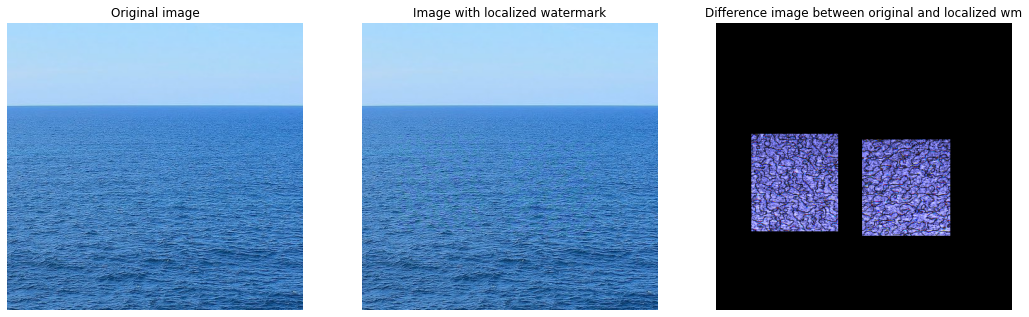

/home/wh/ywy/ywy_env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


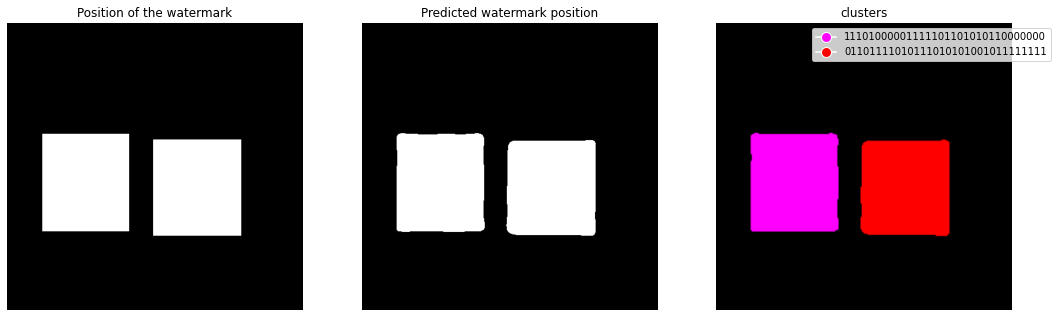

number messages found in image seabackground.jpg: 2
found centroid: 11101000001111101101010110000000
bit accuracy: 1.0 - hamming distance: 0/32
found centroid: 01101111010111010101001011111111
bit accuracy: 1.0 - hamming distance: 0/32


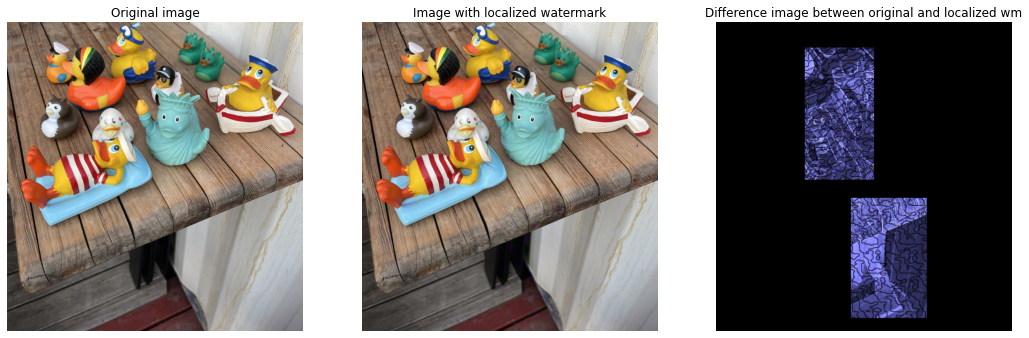

/home/wh/ywy/ywy_env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


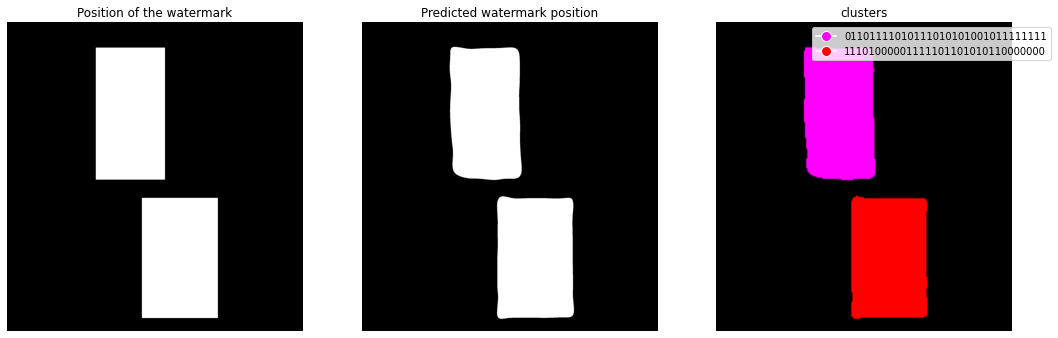

number messages found in image ducks.jpg: 2
found centroid: 01101111010111010101001011111111
bit accuracy: 1.0 - hamming distance: 0/32
found centroid: 11101000001111101101010110000000
bit accuracy: 1.0 - hamming distance: 0/32


In [9]:
from notebooks.inference_utils import multiwm_dbscan

# DBSCAN parameters for detection
epsilon = 1 # min distance between decoded messages in a cluster
min_samples = 500 # min number of pixels in a 256x256 image to form a cluster

# multiple 32 bit message to hide (could be more than 2; does not have to be 1 minus the other)
wm_msgs = wam.get_random_msg(2)
print("Original messages: ", [msg2str(msg) for msg in wm_msgs])
proportion_masked = 0.1 # max proportion per watermark, randomly placed

for img_ in os.listdir(img_dir)[:num_imgs]:
    # Load and preprocess the image
    img_pt = load_img(os.path.join(img_dir, img_))  # [1, 3, H, W]
    
    # Mask to use. 1 values correspond to pixels where the watermark will be placed.
    masks = create_random_mask(img_pt, num_masks=len(wm_msgs), mask_percentage=proportion_masked)  # create one random mask per message
    multi_wm_img = img_pt.clone()
    for ii in range(len(wm_msgs)):
        wm_msg, mask = wm_msgs[ii].unsqueeze(0), masks[ii]
        outputs = wam.embed(img_pt, wm_msg) 
        multi_wm_img = outputs['imgs_w'] * mask + multi_wm_img * (1 - mask)  # [1, 3, H, W]

    # Detect the watermark in the multi-watermarked image
    preds = wam.detect(multi_wm_img)["preds"]  # [1, 33, 256, 256]
    mask_preds = F.sigmoid(preds[:, 0, :, :])  # [1, 256, 256], predicted mask
    mask_preds_res = F.interpolate(mask_preds.unsqueeze(1), size=(img_pt.shape[-2], img_pt.shape[-1]), mode="bilinear", align_corners=False)  # [1, 1, H, W]
    bit_preds = preds[:, 1:, :, :]  # [1, 32, 256, 256], predicted bits

    centroids, positions = multiwm_dbscan(bit_preds, mask_preds, epsilon = epsilon, min_samples = min_samples)
    centroids_pt = torch.stack(list(centroids.values()))
    plot_outputs(img_pt.detach(), multi_wm_img.detach(), masks.sum(0).detach(), (mask_preds_res>0.5).float().detach(), labels = positions, centroids = centroids)
    # positions has the cluster number at each pixel. can be upsaled back to the original size.

    print(f"number messages found in image {img_}: {len(centroids)}")
    for centroid in centroids_pt:
        print(f"found centroid: {msg2str(centroid)}")
        bit_acc = (centroid == wm_msgs).float().mean(dim=1)
        # get message with maximum bit accuracy
        bit_acc, idx = bit_acc.max(dim=0)
        hamming = int(torch.sum(centroid != wm_msgs[idx]).item())
        print(f"bit accuracy: {bit_acc.item()} - hamming distance: {hamming}/{len(wm_msgs[0])}")

### With segmentation masks

Original messages:  ['11100111111110101101011010100110', '11100000000010111000010000010101']


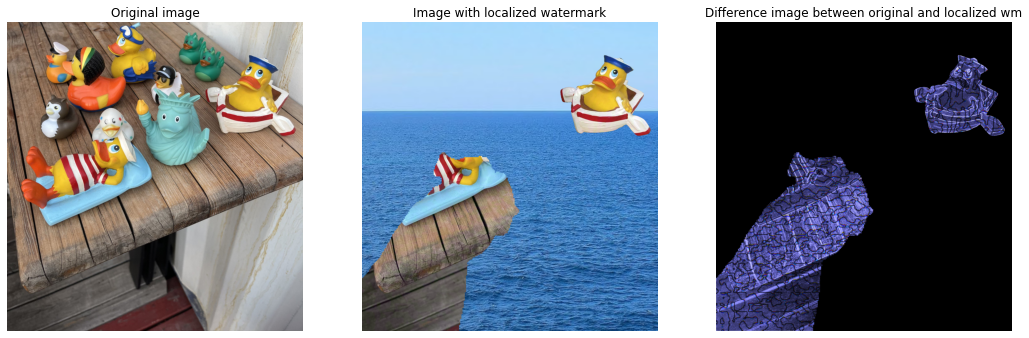

/home/wh/ywy/ywy_env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


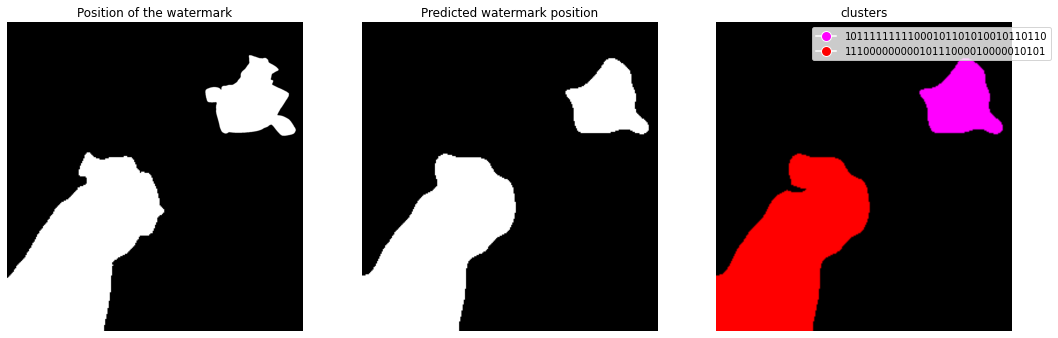

number messages found in image ducks.jpg: 2
found centroid: 10111111111000101101010010110110
bit accuracy: 0.78125 - hamming distance: 7/32
found centroid: 11100000000010111000010000010101
bit accuracy: 1.0 - hamming distance: 0/32


In [10]:
from notebooks.inference_utils import multiwm_dbscan

# DBSCAN parameters for detection
epsilon = 1 # min distance between decoded messages in a cluster
min_samples = 500 # min number of pixels in a 256x256 image to form a cluster

# multiple 32 bit message to hide (could be more than 2; does not have to be 1 minus the other)
wm_msgs = wam.get_random_msg(2)
print("Original messages: ", [msg2str(msg) for msg in wm_msgs])

# load image
img_pt = load_img(os.path.join(img_dir, "ducks.jpg"))

# load background
img_pt_background = load_img(os.path.join(img_dir, "seabackground.jpg"))
img_pt_background = F.interpolate(img_pt_background, size=(img_pt.shape[-2], img_pt.shape[-1]), mode="bilinear", align_corners=False)

multi_wm_img = img_pt_background.clone()

# Creates mask to use. `1` where the watermark will be placed, `0` elsewhere.
masks = []
for duck_nb in [1, 2]:
    mask_path = f'assets/masks/ducks_{duck_nb}.jpg'
    mask = Image.open(mask_path).convert('L')  # Convert to grayscale
    target_shape = (img_pt.shape[-1], img_pt.shape[-2]) 
    mask = mask.resize(target_shape, Image.NEAREST)
    mask_array = np.array(mask) 
    mask_array = (mask_array > 128).astype(np.float32) 
    masks.append(mask_array)
masks = torch.tensor(np.array(masks)).to(device)

for ii in range(len(wm_msgs)):
    wm_msg, mask = wm_msgs[ii].unsqueeze(0), masks[ii]
    outputs = wam.embed(img_pt, wm_msg)
    multi_wm_img = outputs['imgs_w'] * mask + multi_wm_img * (1 - mask)  # [1, 3, H, W]

# Detect the watermark in the multi-watermarked image
preds = wam.detect(multi_wm_img)["preds"]  # [1, 33, 256, 256]
mask_preds = F.sigmoid(preds[:, 0, :, :])  # [1, 256, 256], predicted mask
mask_preds_res = F.interpolate(mask_preds.unsqueeze(1), size=(img_pt.shape[-2], img_pt.shape[-1]), mode="nearest")  # [1, 1, H, W]
bit_preds = preds[:, 1:, :, :]  # [1, 32, 256, 256], predicted bits

centroids, positions = multiwm_dbscan(bit_preds, mask_preds, epsilon = epsilon, min_samples = min_samples)
centroids_pt = torch.stack(list(centroids.values()))
plot_outputs(img_pt.detach(), multi_wm_img.detach(), masks.sum(0).detach(), (mask_preds_res>0.5).float().detach(), labels = positions, centroids = centroids)
# positions has the cluster number at each pixel. can be upsaled back to the original size.

print(f"number messages found in image {img_}: {len(centroids)}")
for centroid in centroids_pt:
    print(f"found centroid: {msg2str(centroid)}")
    bit_acc = (centroid == wm_msgs).float().mean(dim=1)
    # get message with maximum bit accuracy
    bit_acc, idx = bit_acc.max(dim=0)
    hamming = int(torch.sum(centroid != wm_msgs[idx]).item())
    print(f"bit accuracy: {bit_acc.item()} - hamming distance: {hamming}/{len(wm_msgs[0])}")